# Acknowledgement

The following document is taken from [here](https://github.com/unlearning-challenge/starting-kit). This is a re-implementation of the `PyTorch` code to `Keras` code.

---

<img src="https://unlearning-challenge.github.io/Unlearning-logo.png" width="100px">

# NeurIPS 2023 Machine Unlearning Challenge Starting Kit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/unlearning-challenge/starting-kit/main/unlearning-CIFAR10.ipynb)


This notebook is part of the starting kit for the [NeurIPS 2023 Machine Unlearning Challenge](https://unlearning-challenge.github.io/). This notebook explains the pipeline of the challenge and contains sample unlearning and evaluation code.


This notebook has 3 sections:

  * 💾 In the first section we'll load a sample dataset (CIFAR10) and pre-trained model (ResNet18).

  * 🎯 In the second section we'll develop the unlearning algorithm. We start by splitting the original training set into a retain set and a forget set. The goal of an unlearning algorithm is to update the pre-trained model so that it approximates as much as possible a model that has been trained on the retain set but not on the forget set. We provide a simple unlearning algorithm as a starting point for participants to develop their own unlearning algorithms.

  * 🏅 In the third section we'll score our unlearning algorithm using a simple membership inference attacks (MIA). Note that this is a different evaluation than the one that will be used in the competition's submission.
  

We emphasize that this notebook is provided for convenience to help participants quickly get started. Submissions will be scored using a different method than the one provided in this notebook on a different (private) dataset of human faces. To run the notebook, the requirement is to have installed an up-to-date version of Python and Pytorch.

In [1]:
!pip install keras_cv==0.5.0 -q

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection

warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

In [3]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld: 
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [4]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 14352646144
/device:GPU:1 14352646144


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
  PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')],
 '2.12.0')

# 💾 Download dataset and pre-trained model

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = keras.utils.split_dataset(held_out, left_size=0.2)

170498071/170498071 [==============================] - 2s 0us/step


In [6]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465], 
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)], 
        invert=denorm,
        axis=-1,
    )
    
    if not denorm:
        image = rescale(image)
    return norms(image), label


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)


Let us show some of the training images, just for fun.

(128, 32, 32, 3) (128, 1)


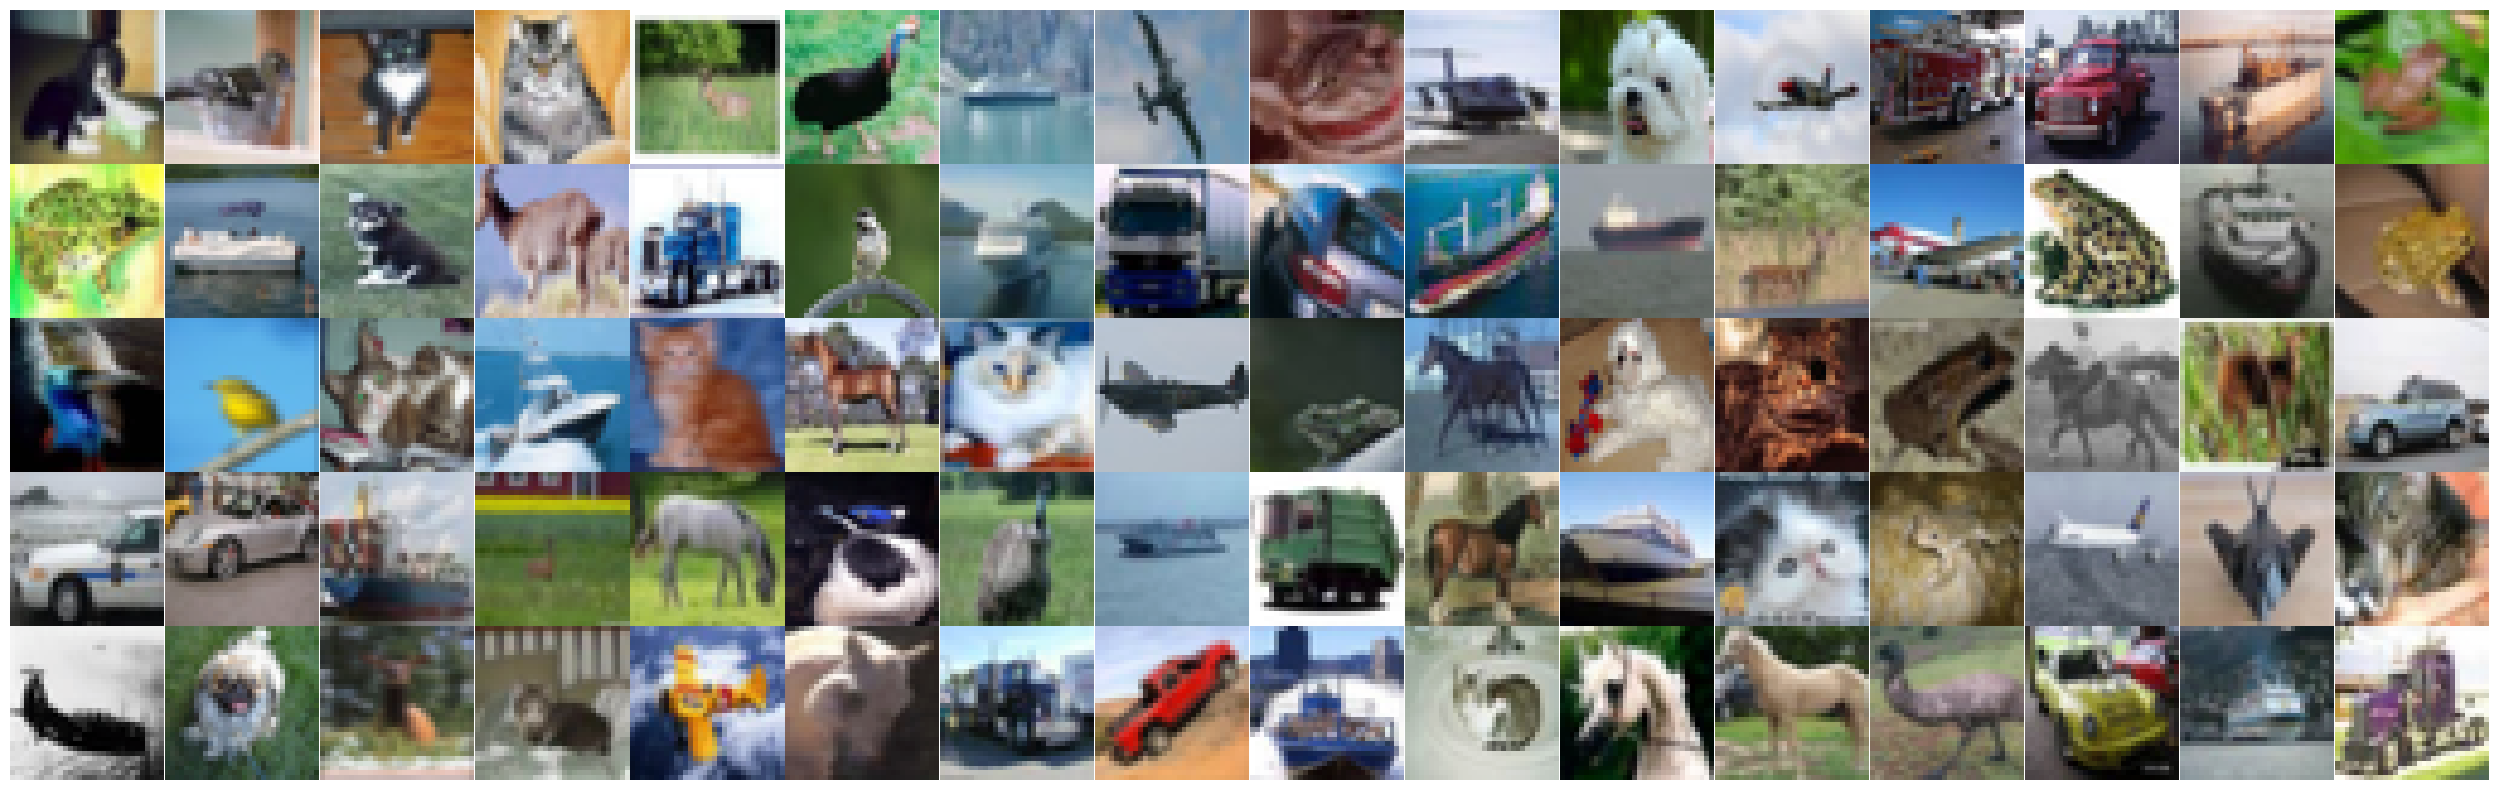

In [8]:
temp_ds = train_ds.map(lambda x,y:normalize(x,y, denorm=True))
images, labels = next(iter(temp_ds))
print(images.shape, labels.shape)

visualization.plot_image_gallery(
    images, value_range=(0, 1), rows=5, cols=16
)


In [9]:
def get_model():
    with strategy.scope():
        model = keras.Sequential(
            [
                ResNet18Backbone(include_rescaling=False, input_shape=(32, 32, 3)),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.compile(
            optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )
    
    return model

In [10]:
model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=20)
model.save("resnet18_cifat10.keras", save_format="keras_v3")

Epoch 1/20
391/391 [==============================] - 88s 116ms/step - loss: 1.4679 - accuracy: 0.4827 - val_loss: 1.3379 - val_accuracy: 0.5529
Epoch 2/20
391/391 [==============================] - 14s 36ms/step - loss: 1.0311 - accuracy: 0.6363 - val_loss: 1.0896 - val_accuracy: 0.6192
Epoch 3/20
391/391 [==============================] - 16s 41ms/step - loss: 0.8389 - accuracy: 0.7047 - val_loss: 1.1898 - val_accuracy: 0.6134
Epoch 4/20
391/391 [==============================] - 15s 38ms/step - loss: 0.7206 - accuracy: 0.7480 - val_loss: 0.9461 - val_accuracy: 0.6858
Epoch 5/20
391/391 [==============================] - 17s 43ms/step - loss: 0.6086 - accuracy: 0.7871 - val_loss: 1.0103 - val_accuracy: 0.6639
Epoch 6/20
391/391 [==============================] - 15s 38ms/step - loss: 0.5178 - accuracy: 0.8169 - val_loss: 0.9732 - val_accuracy: 0.6880
Epoch 7/20
391/391 [==============================] - 14s 35ms/step - loss: 0.4354 - accuracy: 0.8463 - val_loss: 1.0586 - val_accuracy

We'll now compute the model's accuracy on the train and test set. This model has been trained without data augmentation, so generalization accuracy is lower than state-of-the-art models.

In [11]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 13s 31ms/step - loss: 0.0819 - accuracy: 0.9712
Train set accuracy: 97.1%%
16/16 [==============================] - 1s 21ms/step - loss: 1.1672 - accuracy: 0.7610
Test set accuracy: 76.1%%


In [12]:
# new_model = keras.models.load_model("resnet18_cifat10.keras")
# print(new_model.summary())
# print(f"Train set accuracy: {100.0 * new_model.evaluate(train_ds)[-1]:0.1f}%%")
# print(f"Test set accuracy: {100.0 * new_model.evaluate(test_ds)[-1]:0.1f}%%")

# 🎯 Unlearning Algorithm

In this section we develop the unlearning algorithm.

We start by splitting the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

In [13]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
int(forget_ds.cardinality()), int(retain_ds.cardinality())

(40, 352)

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.

Below is a simple unlearning algorithm provided for illustration purposes. We call this algorithm _unlearning by fine-tuning_. It starts from the pre-trained and optimizes for a few epochs on the retain set. This is a very simple unlearning algorithm, but it is not very computationally efficient.

To make a new entry in the competitions, participants will submit an unlearning function with the same API as the one below. Note that the unlearning function takes as input a pre-trained model, a retain set, a forget set and an evaluation set (even though the fine-tuning algorithm below only uses the retain set and ignores the other datasets).

In [14]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : keras.Model.
        pre-trained model to use as base of unlearning.
      retain : tf.data.Dataset.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : tf.data.Dataset.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : tf.data.Dataset.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5
 
    with strategy.scope():
        # loss, metric, scheduler, optimizer
        loss = losses.SparseCategoricalCrossentropy()
        metric = metrics.SparseCategoricalAccuracy(name='accuracy')
        sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
        optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )
        
        # compile the model
        net.compile(
            optimizer=optim, 
            loss=loss, 
            metrics=metric,
        )

    # training
    net.fit(retain, epochs=epochs)
    
    return net


In [17]:
with strategy.scope():
    # load pre-trained model
    net = keras.models.load_model("resnet18_cifat10.keras")

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
model_ft = unlearning(net, retain_ds, forget_ds, test_ds)

Epoch 1/5
352/352 [==============================] - 46s 41ms/step - loss: 1.5872 - accuracy: 0.5529
Epoch 2/5
352/352 [==============================] - 27s 77ms/step - loss: 0.5381 - accuracy: 0.8132
Epoch 3/5
352/352 [==============================] - 12s 34ms/step - loss: 0.1857 - accuracy: 0.9352
Epoch 4/5
352/352 [==============================] - 12s 34ms/step - loss: 0.0477 - accuracy: 0.9844
Epoch 5/5
352/352 [==============================] - 12s 35ms/step - loss: 0.0107 - accuracy: 0.9986


We have now an unlearned model `model_ft`. Besides the forgetting quality (which we'll discuss in the next section), a good unlearning algorithm should retain as much as possible the accuracy on the retain and test set.

To quantify this potential loss of utility, we'll now compute the retain and test accuracies using the unlearned model

In [18]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")

352/352 [==============================] - 8s 9ms/step - loss: 0.0092 - accuracy: 0.9989
Retain set accuracy: 99.9%%
16/16 [==============================] - 1s 65ms/step - loss: 1.2886 - accuracy: 0.7615
Test set accuracy: 76.2%%


# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [19]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        reduction="none"
    )
    all_losses = []

    for inputs, targets in tqdm(loader):
        logits = net(inputs, training=False)
        losses = loss_fn(targets, logits).numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [20]:
train_losses = compute_losses(model, train_ds)
test_losses = compute_losses(model, test_ds)

100%|██████████| 16/16 [00:01<00:00,  9.39it/s]


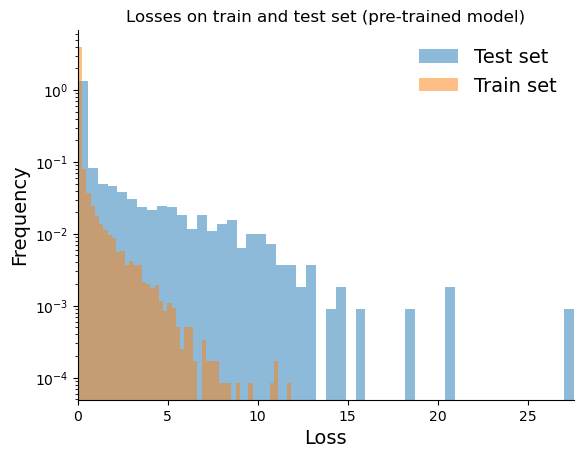

In [21]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

As per the above plot, the distributions of losses are quite different between the train and test sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes. 

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set (associated with an attacker accuracy around random chance).

In [22]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [23]:
forget_losses = compute_losses(model, forget_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[:len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

100%|██████████| 40/40 [00:04<00:00,  8.95it/s]

The MIA attack has an accuracy of 0.629 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [24]:
ft_forget_losses = compute_losses(model_ft, forget_ds)
ft_test_losses = compute_losses(model_ft, test_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(ft_forget_losses)
ft_forget_losses = ft_forget_losses[:len(ft_test_losses)]

samples_mia_ft = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

100%|██████████| 16/16 [00:01<00:00,  9.36it/s]


In [25]:
mia_scores_ft = simple_mia(samples_mia_ft, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores_ft.mean():.3f} on forgotten vs unseen images"
)

The MIA attack has an accuracy of 0.589 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

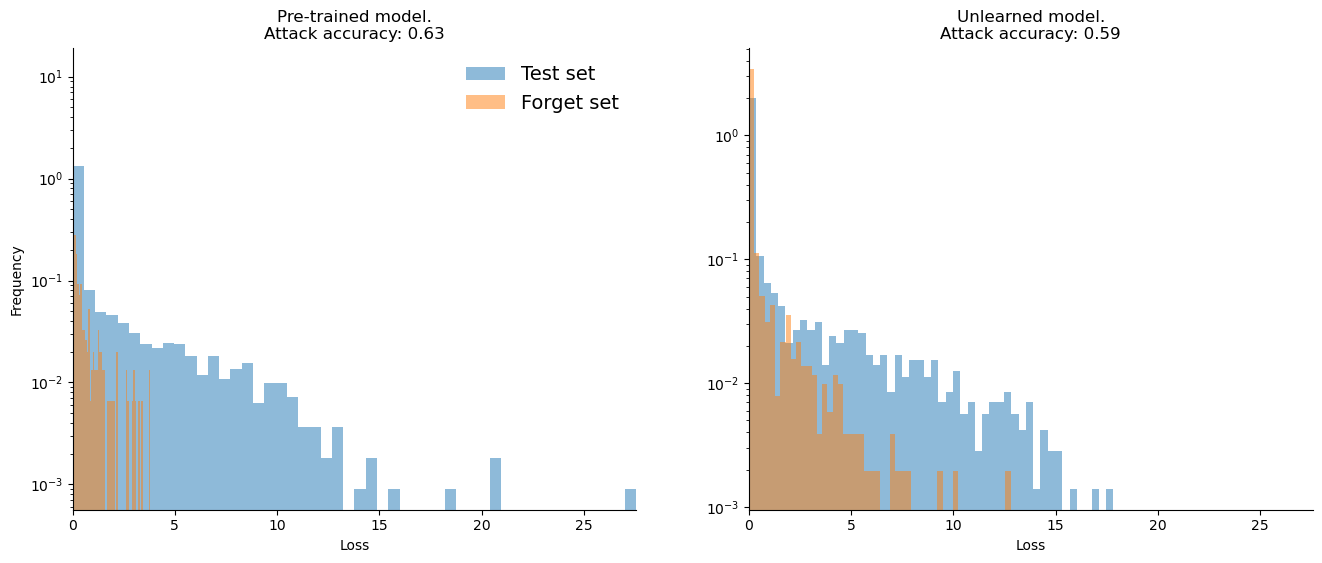

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(f"Unlearned model.\nAttack accuracy: {mia_scores_ft.mean():0.2f}")
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()